In [13]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy

    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')

    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

Running in Google Colab
Encountered 1 file(s) that should have been pointers, but weren't:
	Week_01/assignments/raw_data/example_EM_Image.tif
Colab setup complete!


<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


In [2]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install hyperspy ase py4DSTEM
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Running in Google Colab. Installing requirements...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.1 MB/s eta 0:00:00
Cloning into '465_Computational_Microscopy_2026'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 465 (delta 27), reused 160 (delta 10), pack-reused 275 (from 1)
Receiving objects: 100% (465/465), 54.03 MiB | 22.33 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Filtering content: 100% (2/2), 587.65 MiB | 43.83 MiB/s, done.
Encountered 1 file(s) that should have been pointers, but weren't:
	Week_01/assignments/raw_data/example_EM_Image.tif
Setup complete.


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [9]:
!pip install imagecodecs

In [13]:
# Your code here
import hyperspy.api as hs


In [14]:
import numpy as np
#signal = hs.signals.Signal2D(np.random.random((10,20,30,40)))
signal=hs.load('/content/Si-SiGe.dm4')
signal.axes_manager[0].name='x'
signal.axes_manager[0].units='nm'
signal.axes_manager[0].scale=0.01

signal.axes_manager[1].name='y'
signal.axes_manager[1].units='nm'
signal.axes_manager[1].scale=0.01

signal.axes_manager[2].name='kx'
signal.axes_manager[2].units='nm-1'
signal.axes_manager[2].scale=0.01

signal.axes_manager[3].name='ky'
signal.axes_manager[3].units='nm-1'
signal.axes_manager[3].scale=0.01

In [15]:
signal.axes_manager

Navigation axis name,size,index,offset,scale,units
x,448,0,0.0,0.01,nm
y,480,0,0.0,0.01,nm
Signal axis name,size,,offset,scale,units
kx,17,,0.0,0.01,nm-1
ky,77,,0.0,0.01,nm-1


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [1]:
import py4DSTEM as py4D
import numpy as np
from scipy.ndimage import center_of_mass, shift
def COM_correction(dataset):
  scan_y_dim, scan_x_dim, diff_y_dim, diff_x_dim = dataset.data.shape

  shifts_x = np.zeros((scan_y_dim, scan_x_dim))
  shifts_y = np.zeros((scan_y_dim, scan_x_dim))

  nominal_center_y = diff_y_dim / 2
  nominal_center_x = diff_x_dim / 2

  corrected_data = np.zeros_like(dataset.data)

  for i in range(scan_y_dim):
    for j in range(scan_x_dim):
        diffraction_pattern = dataset.data[i, j, :, :]
        com_y, com_x = center_of_mass(diffraction_pattern)

        dy_correction = nominal_center_y - com_y
        dx_correction = nominal_center_x - com_x

        corrected_data[i, j, :, :] = shift(diffraction_pattern, (dy_correction, dx_correction), order=1, mode='constant', cval=0)
  # Replace the original data with the corrected data
  dataset.data = corrected_data
  return dataset.data


In [5]:
dataset=py4D.io.import_file('/content/Si-SiGe.dm4')
#dataset.data=dataset.data.transpose(2,3,0,1)
dataset.swap_RQ()

DataCube( A 4-dimensional array of shape (77, 17, 480, 448) called 'dm_dataset',
          with dimensions:

              Rx = [0,1,2,...] pixels
              Ry = [0,1,2,...] pixels
              Qx = [0,1,2,...] pixels
              Qy = [0,1,2,...] pixels
)

In [6]:
from ncempy.io import dm
metadata=dm.dmReader("/content/Si-SiGe.dm4")
print(metadata['pixelUnit'])
print(metadata['pixelSize'])

['1/nm', '1/nm', 'nm', 'nm']
[0.06208537, 0.06208537, 2.0, 2.0]


In [7]:
dataset.calibration.R_pixel_size=2
dataset.calibration.R_pixel_units='nm'
dataset.calibration.Q_pixel_size=0.06*10
dataset.calibration.Q_pixel_units='A^-1'
print(dataset.calibration)

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.6
             R_pixel_size:    2
             Q_pixel_units:   A^-1
             R_pixel_units:   nm
             QR_flip:         False
)


In [8]:
dataset.data=COM_correction(dataset)

## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

In [9]:
def virtual_BF(dataset):
  dp_mean = dataset.get_dp_mean()
  center = (dataset.shape[2]/2,dataset.shape[3]/2)
  radius = 15
  from py4DSTEM import show
  dataset.position_detector(
    mode = 'circle',
    geometry = (
        center,
        radius
    ))
  dataset.get_virtual_image(
      mode = 'circle',
      geometry = (center,radius),
      name = 'bright_field',       # the output will be stored in `datacube`'s tree with this name
  )
  show( dataset.tree('bright_field') )


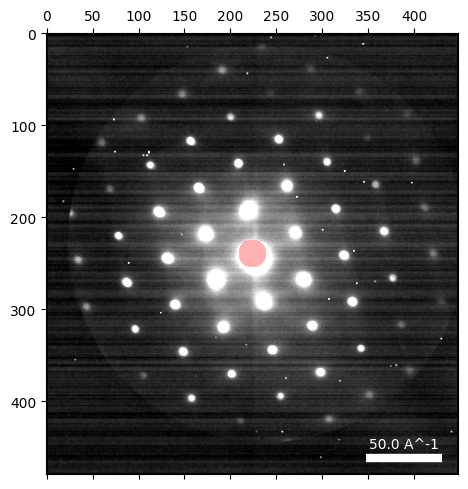

100%|██████████| 1309/1309 [00:03<00:00, 350.04it/s]


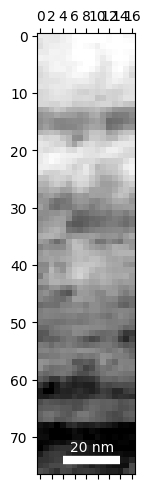

In [10]:
virtual_BF(dataset)

In [11]:
from py4DSTEM import show
def virtual_DF(dataset):
  dp_mean = dataset.get_dp_mean()
  probe_semiangle, probe_qx0, probe_qy0 = dataset.get_probe_size(
    dp_mean.data,
)
  center = probe_qx0, probe_qy0
  r_inner = probe_semiangle * 3
  r_outer = probe_semiangle * 6
  radii = r_inner,r_outer

  dataset.position_detector(
    mode = 'annular',
    geometry = (
        center,
        radii
    )
  )
  dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii),
    name = 'annular_dark_field'
  )

  # show
  import matplotlib.pyplot as plt
  show(dataset.tree('annular_dark_field'),scalebar=True,show_cbar=False,cmap='magma')




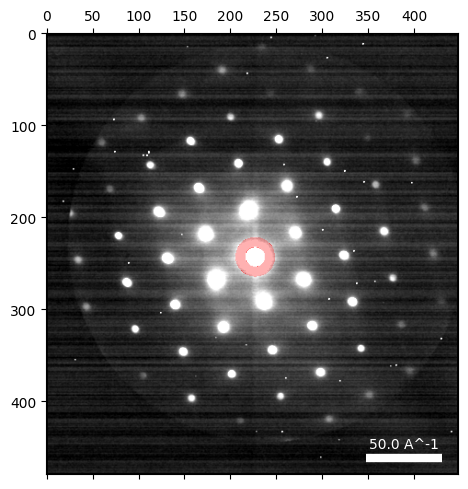

100%|██████████| 1309/1309 [00:03<00:00, 343.69it/s]


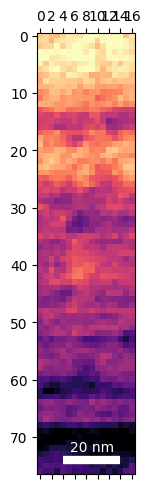

In [12]:
virtual_DF(dataset)

## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.

In [ ]:
# Your code here